# 2do

- test if unet wrapper works 
- collect different loss functions to use
- save every xth epoch
- write logs with evaluation scores on test set
- double check if scheduler reduces lr

In [1]:
import configparser

In [2]:
config = configparser.ConfigParser()
config.read("src/config.ini")

['src/config.ini']

In [3]:
config["Training"]["epochs"]

'100'

In [4]:
import matplotlib.pyplot as plt
import torch 
import PIL
from PIL import Image
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from torchvision.transforms import ToTensor
PIL.Image.MAX_IMAGE_PIXELS = 933120000
from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision.transforms import ToTensor


In [5]:
from src.u_net import Unet
from src.dataloader import MiceHeartDataset

In [6]:
dataset_train = MiceHeartDataset(image_path="example_data", resolution=256, num_images_for_testing=1)
# dataset_test = MiceHeartDataset(image_path="data", train=False, resolution=512)

In [7]:
dataloader_train = DataLoader(dataset=dataset_train, batch_size=2, shuffle=True,)

In [8]:
model = Unet().cuda()

In [10]:
import torch.optim.lr_scheduler as lr_scheduler

In [13]:
loss_fn = torch.nn.BCEWithLogitsLoss().cuda()  # Assuming just 5% positive pixels
epochs = 1
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=0.000005, total_iters=2)
scaler = GradScaler()  # Scale gradients to prevent underflow


In [14]:
loss_hist_train = []
loss_hist_test = []

for epoch in range(100):
    model.train()
    for i, data in enumerate(dataloader_train):
        # Every data instance is an input + label pair
        inputs, labels = data

        inputs = inputs.cuda().float()
        labels = labels.cuda().float()

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        with autocast("cuda"):
            # Make predictions for this batch
            outputs = model(inputs)

            # Compute the loss and its gradients
            loss_value = loss_fn(outputs, labels)

        loss_hist_train.append(loss_value.item())
        print(loss_value.item())

        scaler.scale(loss_value).backward()
        scaler.step(optimizer)
        scaler.update()

0.5411112308502197
0.6093363761901855
0.5727866291999817
0.5699955224990845
0.5622745752334595
0.5596249103546143
0.5565669536590576
0.5529578924179077
0.5492597222328186
0.5433653593063354
0.5331888198852539
0.5207031965255737
0.5103450417518616
0.5147162675857544
0.509431779384613
0.5049444437026978
0.4991694688796997
0.4965135455131531
0.49329906702041626
0.4904227554798126
0.48871007561683655
0.4857923984527588
0.48349887132644653


KeyboardInterrupt: 

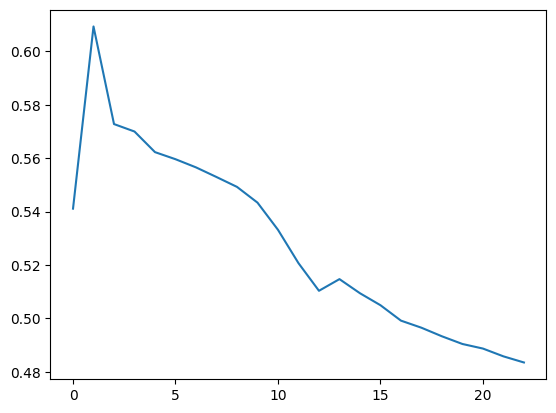

In [15]:
plt.plot(loss_hist_train)
plt.plot(loss_hist_test)

In [16]:
import torch.nn.functional as F

In [17]:
def dice_coef(groundtruth_mask, pred_mask):
    intersect = torch.sum(pred_mask*groundtruth_mask)
    total_sum = torch.sum(pred_mask) + torch.sum(groundtruth_mask)
    dice = torch.mean(2*intersect/total_sum)
    return dice

def iou(groundtruth_mask, pred_mask):
    intersect = torch.sum(pred_mask*groundtruth_mask)
    union = torch.sum(pred_mask) + torch.sum(groundtruth_mask) - intersect
    iou = torch.mean(intersect/union)
    return iou

In [18]:
labels.max()

tensor(1., device='cuda:0')

tensor(0.3393, device='cuda:0')
tensor(0.2267, device='cuda:0') tensor(0.1278, device='cuda:0')


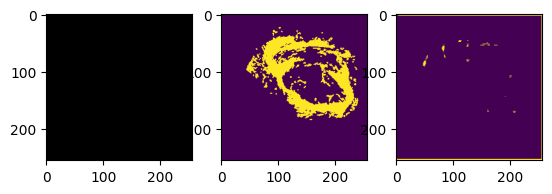

In [26]:
model.eval()

with torch.no_grad():
    for i, data in enumerate(dataloader_train):
        inputs, labels = data
        labels = labels.cuda()
        outputs = F.sigmoid(model(inputs.float().cuda()))
        print(outputs.min())
        print(dice_coef(labels, outputs), iou(labels, outputs))
        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(inputs.cpu()[0].permute(1,2,0))
        axarr[1].imshow(labels[0][0].cpu())
        axarr[2].imshow(outputs[0][0].cpu())
        plt.show()

        

In [20]:
print(outputs.max(), outputs.min())

tensor(0.5061, device='cuda:0') tensor(0.3393, device='cuda:0')
